<a href="https://colab.research.google.com/github/bhavna-joshi01128/Python/blob/main/MLproject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

%config InlineBackend.figure_format = 'retina'

In [3]:
from fastai.vision import *
from fastai.metrics import error_rate
from pathlib import Path
from glob2 import glob
from sklearn.metrics import confusion_matrix

import pandas as pd
import numpy as np
import os
import zipfile as zf
import shutil
import re
import seaborn as sns

In [6]:
files = zf.ZipFile("/usr/lib/python3.7/dataset-resized.zip",'r')
files.extractall()
files.close()

In [7]:
os.listdir(os.path.join(os.getcwd(),"dataset-resized"))

['paper', 'glass', 'metal', 'trash', 'plastic', '.DS_Store', 'cardboard']

In [8]:
## helper functions ##

## splits indices for a folder into train, validation, and test indices with random sampling
    ## input: folder path
    ## output: train, valid, and test indices    
def split_indices(folder,seed1,seed2):    
    n = len(os.listdir(folder))
    full_set = list(range(1,n+1))

    ## train indices
    random.seed(seed1)
    train = random.sample(list(range(1,n+1)),int(.5*n))

    ## temp
    remain = list(set(full_set)-set(train))

    ## separate remaining into validation and test
    random.seed(seed2)
    valid = random.sample(remain,int(.5*len(remain)))
    test = list(set(remain)-set(valid))
    
    return(train,valid,test)

## gets file names for a particular type of trash, given indices
    ## input: waste category and indices
    ## output: file names 
def get_names(waste_type,indices):
    file_names = [waste_type+str(i)+".jpg" for i in indices]
    return(file_names)    

## moves group of source files to another folder
    ## input: list of source files and destination folder
    ## no output
def move_files(source_files,destination_folder):
    for file in source_files:
        shutil.move(file,destination_folder)

In [9]:
## paths will be train/cardboard, train/glass, etc...
subsets = ['train','valid']
waste_types = ['cardboard','glass','metal','paper','plastic','trash']

## create destination folders for data subset and waste type
for subset in subsets:
    for waste_type in waste_types:
        folder = os.path.join('data',subset,waste_type)
        if not os.path.exists(folder):
            os.makedirs(folder)
            
if not os.path.exists(os.path.join('data','test')):
    os.makedirs(os.path.join('data','test'))
            
## move files to destination folders for each waste type
for waste_type in waste_types:
    source_folder = os.path.join('dataset-resized',waste_type)
    train_ind, valid_ind, test_ind = split_indices(source_folder,1,1)
    
    ## move source files to train
    train_names = get_names(waste_type,train_ind)
    train_source_files = [os.path.join(source_folder,name) for name in train_names]
    train_dest = "data/train/"+waste_type
    move_files(train_source_files,train_dest)
    
    ## move source files to valid
    valid_names = get_names(waste_type,valid_ind)
    valid_source_files = [os.path.join(source_folder,name) for name in valid_names]
    valid_dest = "data/valid/"+waste_type
    move_files(valid_source_files,valid_dest)
    
    ## move source files to test
    test_names = get_names(waste_type,test_ind)
    test_source_files = [os.path.join(source_folder,name) for name in test_names]
    ## I use data/test here because the images can be mixed up
    move_files(test_source_files,"data/test")

In [10]:
## get a path to the folder with images
path = Path(os.getcwd())/"data"
path

PosixPath('/content/data')

In [11]:
tfms = get_transforms(do_flip=True,flip_vert=True)
data = ImageDataBunch.from_folder(path,test="test",ds_tfms=tfms,bs=16)

/usr/local/lib/python3.7/dist-packages/fastai/vision/transform.py:247: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:766.)
  return _solve_func(B,A)[0][:,0]


In [12]:
data

ImageDataBunch;

Train: LabelList (1262 items)
x: ImageList
Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512)
y: CategoryList
paper,paper,paper,paper,paper
Path: /content/data;

Valid: LabelList (630 items)
x: ImageList
Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512)
y: CategoryList
paper,paper,paper,paper,paper
Path: /content/data;

Test: LabelList (635 items)
x: ImageList
Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512)
y: EmptyLabelList
,,,,
Path: /content/data

In [13]:
print(data.classes)

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


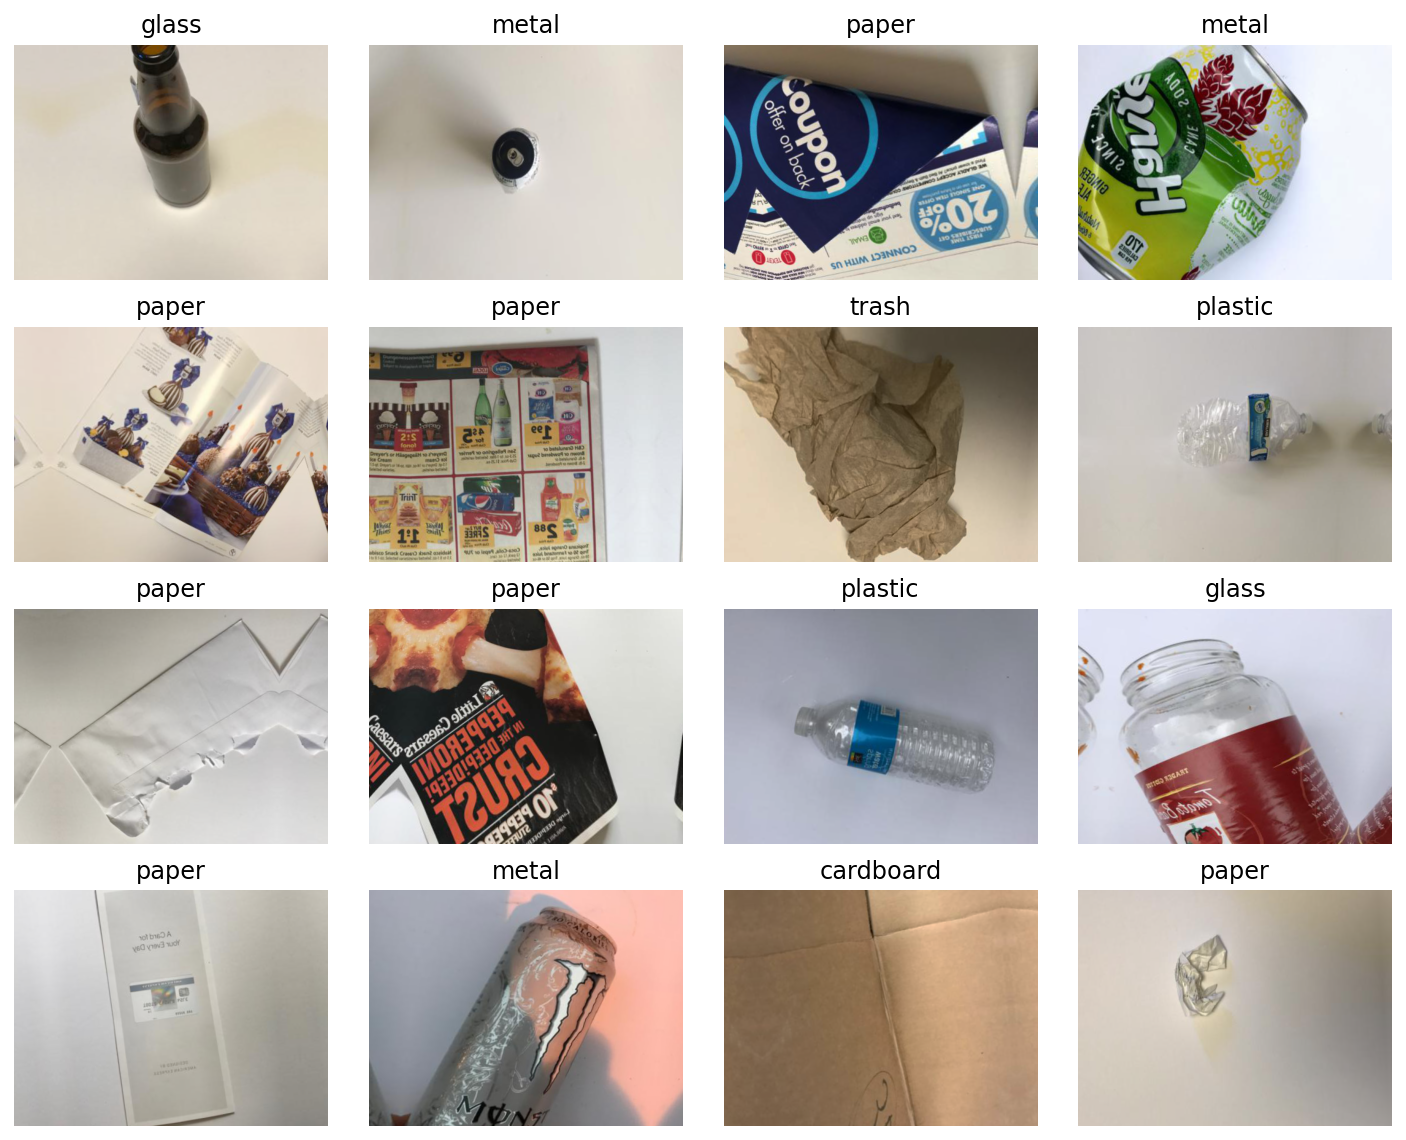

In [14]:
data.show_batch(rows=4,figsize=(10,8))

In [15]:
learn = create_cnn(data,models.resnet34,metrics=error_rate)

/usr/local/lib/python3.7/dist-packages/fastai/vision/learner.py:109: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [16]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


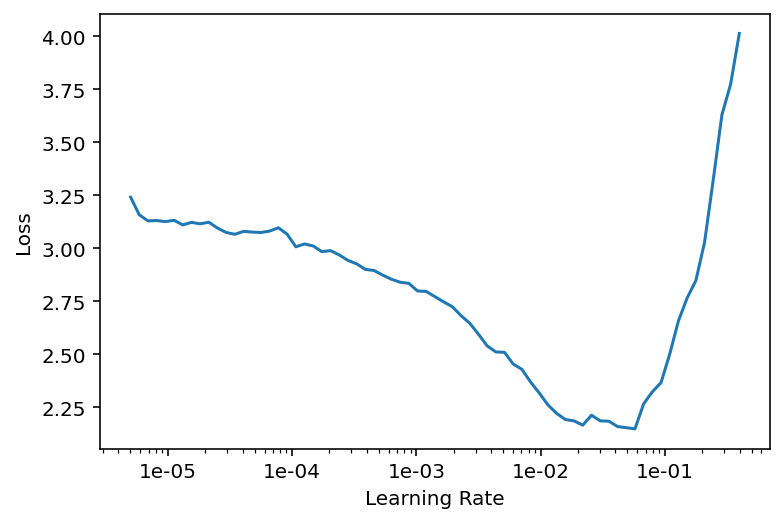

In [17]:
learn.lr_find(start_lr=1e-6,end_lr=1e1)
learn.recorder.plot()

In [21]:
learn.fit_one_cycle(4,max_lr=5.13e-03)

epoch,train_loss,valid_loss,error_rate,time
0,1.388047,0.914253,0.241270,29:02
1,1.079391,0.713519,0.204762,28:52
2,0.780948,0.412324,0.141270,28:48
3,0.611208,0.351743,0.122222,29:02


In [22]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()

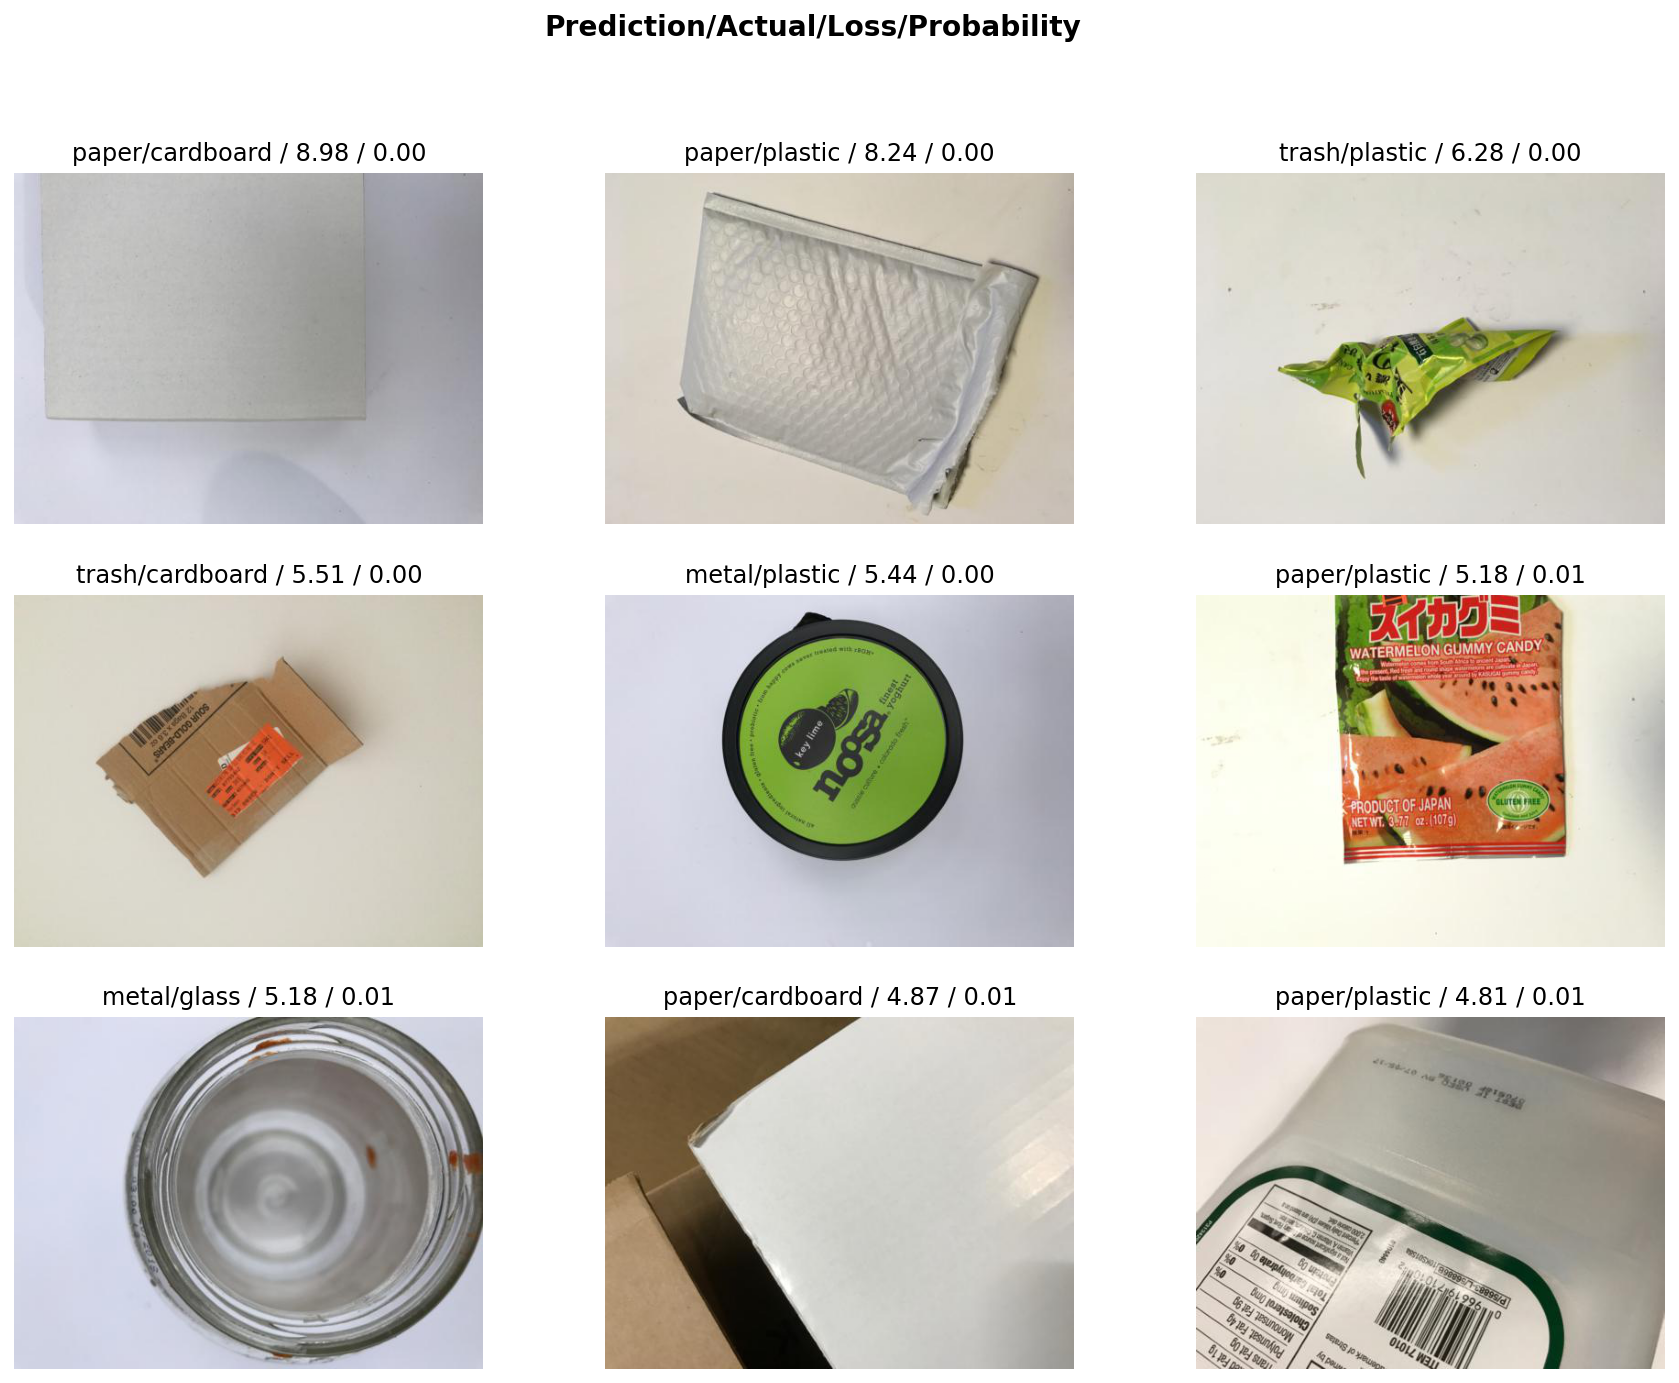

In [23]:
interp.plot_top_losses(9, figsize=(15,11))

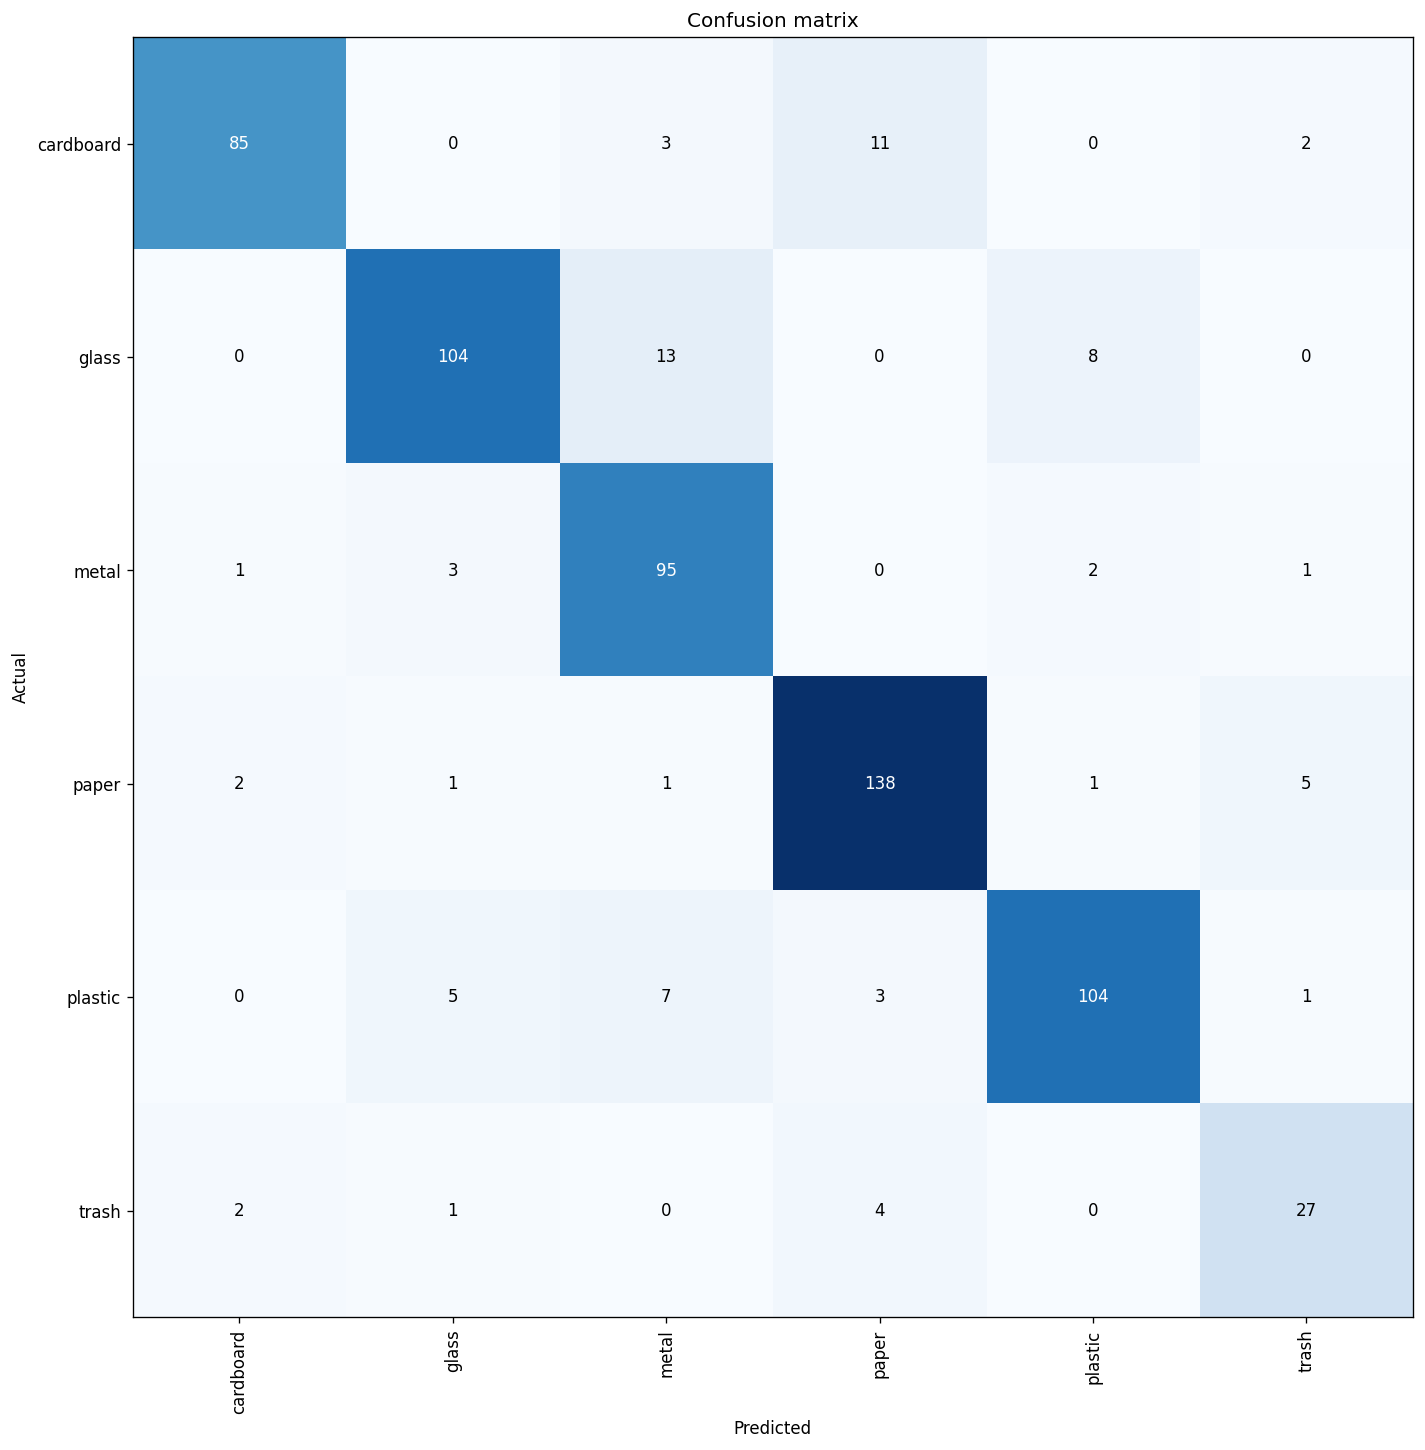

In [24]:
doc(interp.plot_top_losses)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [25]:
interp.most_confused(min_val=2)

[('glass', 'metal', 13),
 ('cardboard', 'paper', 11),
 ('glass', 'plastic', 8),
 ('plastic', 'metal', 7),
 ('paper', 'trash', 5),
 ('plastic', 'glass', 5),
 ('trash', 'paper', 4),
 ('cardboard', 'metal', 3),
 ('metal', 'glass', 3),
 ('plastic', 'paper', 3),
 ('cardboard', 'trash', 2),
 ('metal', 'plastic', 2),
 ('paper', 'cardboard', 2),
 ('trash', 'cardboard', 2)]

In [26]:
preds = learn.get_preds(ds_type=DatasetType.Test)

In [27]:
print(preds[0].shape)
preds[0]

torch.Size([635, 6])


tensor([[9.9924e-01, 5.3666e-07, 1.7939e-07, 2.9647e-04, 5.3285e-07, 4.5898e-04],
        [3.4319e-04, 5.3063e-01, 3.9824e-01, 7.3644e-03, 2.2034e-02, 4.1388e-02],
        [5.6089e-04, 9.7596e-04, 9.9265e-01, 4.8066e-03, 1.5659e-04, 8.5302e-04],
        ...,
        [4.9790e-03, 2.4716e-01, 7.1644e-01, 3.0453e-03, 1.9868e-02, 8.5100e-03],
        [1.4788e-06, 9.7333e-01, 5.3670e-05, 5.0846e-06, 2.6128e-02, 4.7698e-04],
        [1.2706e-05, 1.3118e-03, 1.3576e-04, 1.1556e-06, 9.9851e-01, 2.5530e-05]])

In [28]:
data.classes

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

In [29]:
## saves the index (0 to 5) of most likely (max) predicted class for each image
max_idxs = np.asarray(np.argmax(preds[0],axis=1))

In [30]:
yhat = []
for max_idx in max_idxs:
    yhat.append(data.classes[max_idx])

In [31]:
yhat

['cardboard',
 'glass',
 'metal',
 'paper',
 'metal',
 'plastic',
 'glass',
 'glass',
 'glass',
 'paper',
 'metal',
 'paper',
 'plastic',
 'cardboard',
 'plastic',
 'paper',
 'paper',
 'metal',
 'glass',
 'paper',
 'trash',
 'glass',
 'plastic',
 'metal',
 'paper',
 'plastic',
 'cardboard',
 'paper',
 'metal',
 'metal',
 'trash',
 'glass',
 'cardboard',
 'glass',
 'paper',
 'paper',
 'paper',
 'plastic',
 'metal',
 'paper',
 'plastic',
 'glass',
 'cardboard',
 'paper',
 'plastic',
 'plastic',
 'cardboard',
 'metal',
 'paper',
 'plastic',
 'trash',
 'cardboard',
 'paper',
 'plastic',
 'metal',
 'metal',
 'plastic',
 'plastic',
 'paper',
 'cardboard',
 'plastic',
 'metal',
 'metal',
 'metal',
 'cardboard',
 'metal',
 'glass',
 'paper',
 'paper',
 'metal',
 'glass',
 'paper',
 'paper',
 'plastic',
 'cardboard',
 'glass',
 'trash',
 'glass',
 'trash',
 'glass',
 'glass',
 'cardboard',
 'metal',
 'paper',
 'cardboard',
 'glass',
 'glass',
 'metal',
 'trash',
 'cardboard',
 'plastic',
 'pape

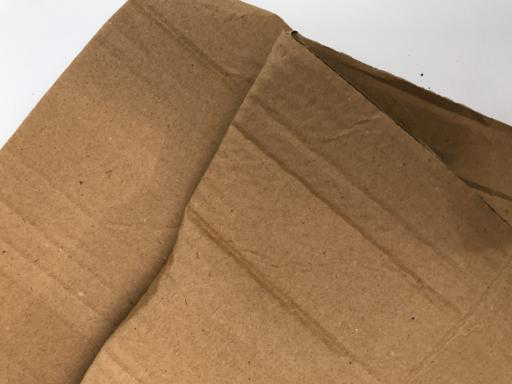

In [36]:
learn.data.test_ds[0][0]

In [37]:
y = []

## convert POSIX paths to string first
for label_path in data.test_ds.items:
    y.append(str(label_path))
    
## then extract waste type from file path
pattern = re.compile("([a-z]+)[0-9]+")
for i in range(len(y)):
    y[i] = pattern.search(y[i]).group(1)

In [38]:
## predicted values
print(yhat[0:5])
## actual values
print(y[0:5])

['cardboard', 'glass', 'metal', 'paper', 'metal']
['cardboard', 'metal', 'metal', 'paper', 'metal']


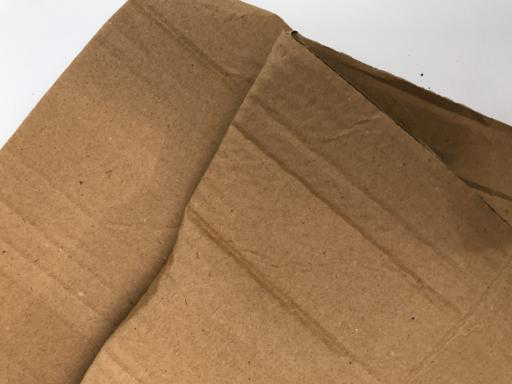

In [39]:
learn.data.test_ds[0][0]

In [40]:
cm = confusion_matrix(y,yhat)
print(cm)

[[ 92   0   3   6   0   0]
 [  0 106  12   0   8   0]
 [  0   6  91   0   2   4]
 [  0   1   1 140   1   6]
 [  0   8   3   0 107   3]
 [  2   0   3   3   1  26]]


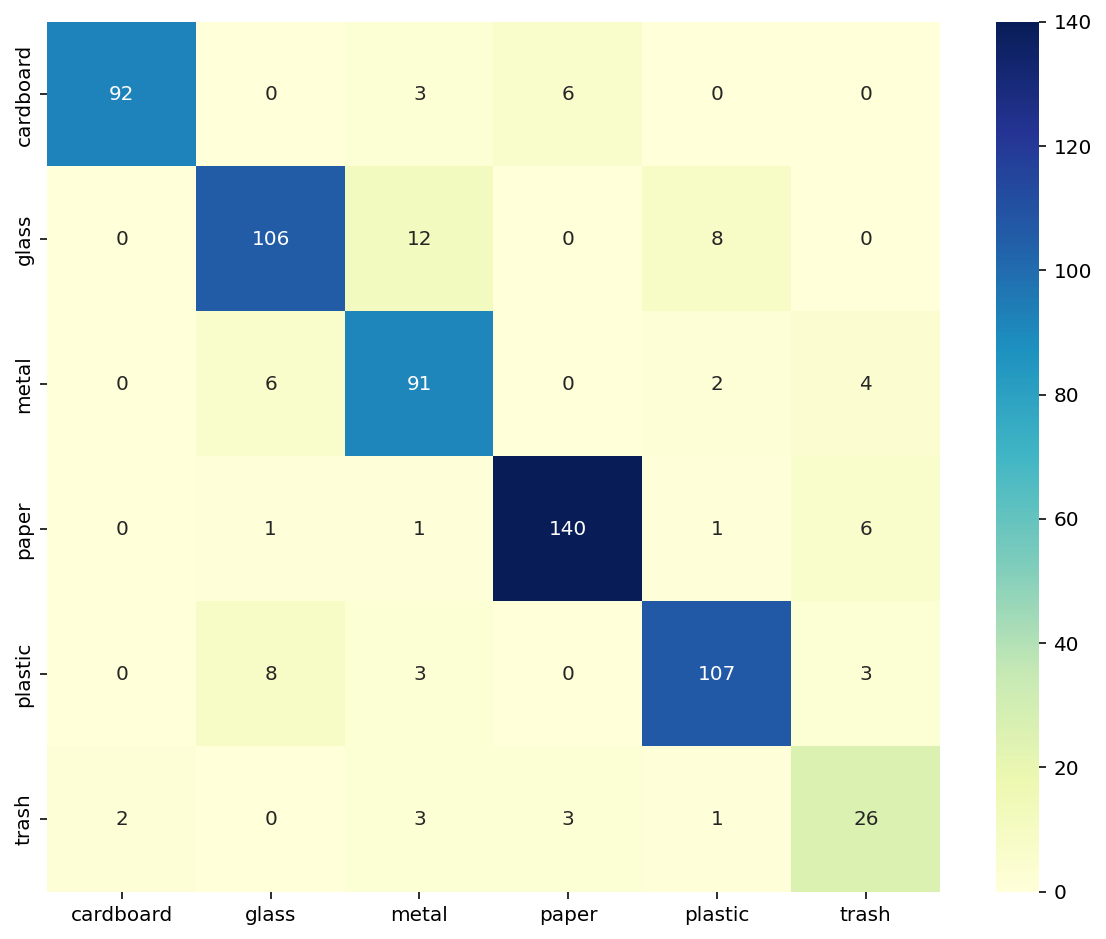

In [41]:
df_cm = pd.DataFrame(cm,waste_types,waste_types)

plt.figure(figsize=(10,8))
sns.heatmap(df_cm,annot=True,fmt="d",cmap="YlGnBu")

In [42]:
correct = 0

for r in range(len(cm)):
    for c in range(len(cm)):
        if (r==c):
            correct += cm[r,c]

In [43]:
accuracy = correct/sum(sum(cm))
accuracy

0.8850393700787401